# **Project: Amazon Product Recommendation System**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

## **Importing the necessary libraries and overview of the dataset**

In [1]:
import pandas as pd # To work with dataframes and datasets
import numpy as np # To work with arrays
import matplotlib.pyplot as plt # To visualize data
import seaborn as sns # To visualize data
from collections import defaultdict # A dictionary output that does not raise a key error

### **Loading the data**

In [2]:
# Filename
filename1 = 'ratings_Electronics.csv'

# Load file
col_names = ['user_id', 'prod_id', 'rating', 'timestamp']
df1 = pd.read_csv(filepath_or_buffer = filename1, header = None, names = col_names)
df1 = df1.drop(columns = ['timestamp'], )

# Preview dataframe
df1.sample(5)

,user_id,prod_id,rating
1262387,A2FCMRQUSA6T66,B000OTF6G0,5.0
7083438,A2ASQNDVIB10XS,B00BEHRQB4,5.0
4830183,A97A35POLBNIM,B005CS723I,5.0
2684443,A3S244NJHD74AV,B002LGXYJ0,5.0
2127518,A1CXRRHLEXTUM6,B001LYX3MQ,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [3]:
# Get rating_count by user_id and only include user_id that have rating_count >= 50
df_user_rating_count = (
  df1
  .groupby('user_id')
  .aggregate(rating_count = ('user_id', 'count'))
)[lambda x: x['rating_count'] >= 50].sort_values(by = 'rating_count', ascending = False).reset_index()

# Display df_user_rating_count
df_user_rating_count      

,user_id,rating_count
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
...,...,...
1535,A2ER8G4JJJ7XER,50
1536,A2F4HP0J5VNOYR,50
1537,A17RFKCYS69M3Y,50
1538,A3CP3J7OEGQMD5,50


In [4]:
# Remove user_id not meeting criteria
cond = df1['user_id'].isin(df_user_rating_count['user_id'])
df2 = df1.copy().loc[cond, :]

In [5]:
# Get rating_count by prod_id and only include prod_id that have rating_count >= 5
df_prod_rating_count = (
  df2
  .groupby('prod_id')
  .aggregate(rating_count = ('prod_id', 'count'))
)[lambda x: x['rating_count'] >= 5].sort_values(by = 'rating_count', ascending = False).reset_index()

# Display df_prod_rating_count
display(df_prod_rating_count)

# Create dictionary storing (prod_id, rating_count) pair
temp = df_prod_rating_count.to_records(index = False).tolist()
dict_prod_rating_count = dict(temp)                            

,prod_id,rating_count
0,B0088CJT4U,206
1,B003ES5ZUU,184
2,B000N99BBC,167
3,B007WTAJTO,164
4,B00829TIEK,149
...,...,...
5684,B00368CDH6,5
5685,B0036AZA6A,5
5686,B0036E8V08,5
5687,B0036QL1JY,5


In [6]:
# Remove prod_id not meeting criteria
cond = df2['prod_id'].isin(df_prod_rating_count['prod_id'])
df3 = df2.copy().loc[cond, :].reset_index(drop = 'index')
df3

,user_id,prod_id,rating
0,A3LDPF5FMB782Z,1400501466,5.0
1,A1A5KUIIIHFF4U,1400501466,1.0
2,A2XIOXRRYX0KZY,1400501466,3.0
3,AW3LX47IHPFRL,1400501466,5.0
4,A1E3OB6QMBKRYZ,1400501466,1.0
...,...,...,...
65285,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
65286,A1G650TTTHEAL5,B00LGQ6HL8,5.0
65287,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
65288,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [7]:
# Check the number of rows and columns and provide observations
df3.shape

(65290, 3)

**Observations:**

- The final dataframe has 65,290 rows and 3 columns.

### **Data types**

In [8]:
# Check Data types and provide observations
df3.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Observations:**

- Both user_id and prod_id columns have object values and the rating column contains float values.

### **Checking for missing values**

In [9]:
# Check for missing values present and provide observations
df3.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**

- There are no missing values in any of the columns.

### **Summary Statistics**

In [10]:
# Summary statistics of 'rating' variable and provide observations
df3['rating'].describe().round(2)

count    65290.00
mean         4.29
std          0.99
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: rating, dtype: float64

**Observations:**

- There are a total of 65,290 ratings. 
- The mean rating is 4.29, with a standard deviation of 1.00. 
- The median rating is 5.00 suggesting a negative skew since the mean rating is less than the median rating. 
- Generally, most frequently occurring ratings are within the range 4.00 to 5.00, and this represents an interqartile range of 1.00 (i.e. 75th percentile - 25th percentile). 

### **Checking the rating distribution**

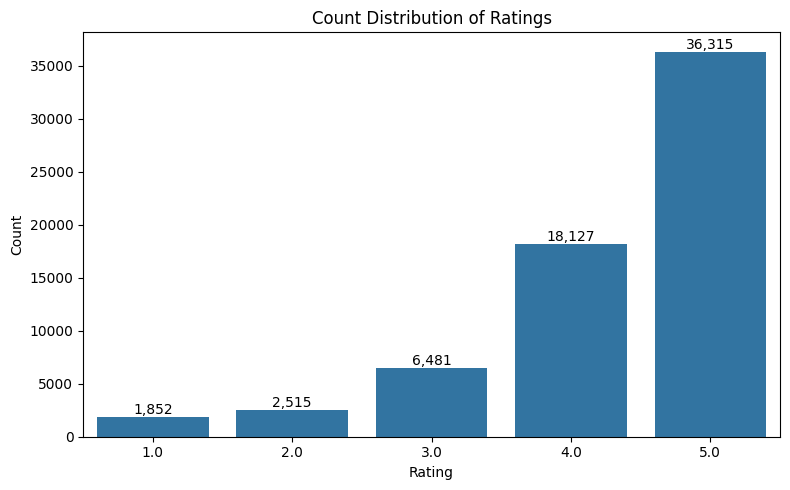

In [11]:
# Create the bar plot and provide observations
plt.figure(figsize = (8, 5))
temp = pd.DataFrame(df3['rating'].value_counts()).reset_index()
p1 = sns.barplot(data = temp, x = 'rating', y = 'count')
p1.bar_label(p1.containers[0], fmt = '{:,.0f}', label_type = 'edge')
plt.title('Count Distribution of Ratings')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()

**Observations:**

- Higher ratings are exponentially more frequent. The most common rating is 5.0 and there is heavy negative skew on the ratings distribution.

### **Checking the number of unique users and items in the dataset**

In [12]:
# Number of total rows in the data and number of unique user id and product id in the data
df3.describe(include = 'object')

,user_id,prod_id
count,65290,65290
unique,1540,5689
top,ADLVFFE4VBT8,B0088CJT4U
freq,295,206


**Observations:**

- The data has 65,290 rows. There are 1,540 unique user_id and 5,689 unique prod_id.

### **Users with the most number of ratings**

In [13]:
# Top 10 users based on the number of ratings
df3['user_id'].value_counts()[:10].to_frame().reset_index()

,user_id,count
0,ADLVFFE4VBT8,295
1,A3OXHLG6DIBRW8,230
2,A1ODOGXEYECQQ8,217
3,A36K2N527TXXJN,212
4,A25C2M3QF9G7OQ,203
5,A680RUE1FDO8B,196
6,A1UQBFCERIP7VJ,193
7,A22CW0ZHY3NJH8,193
8,AWPODHOB4GFWL,184
9,AGVWTYW0ULXHT,179


**Observations:**

- The top 10 users with their respective rating counts are: (1) ADLVFFE4VBT8 - 295, (2) A3OXHLG6DIBRW8 - 230, (3) A1ODOGXEYECQQ8 - 217, (4) A36K2N527TXXJN - 212, (5) A25C2M3QF9G7OQ - 203, (6) A680RUE1FDO8B - 196, (7) A1UQBFCERIP7VJ - 193, (8) A22CW0ZHY3NJH8 - 193, (9) AWPODHOB4GFWL - 184, (10) AGVWTYW0ULXHT - 179

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [14]:
# Create a dataframe with calculated average and count of ratings and sort by average rating in descending order
df_product_ratings = (
  df3
  .groupby('prod_id')
  .aggregate(
    rating_avg = ('rating', 'mean'), 
    rating_count = ('rating', 'count')
  )
).round(2).reset_index().sort_values(by = 'rating_avg', ascending = False)

# See the first five records of the dataset
df_product_ratings.head(5)

,prod_id,rating_avg,rating_count
5688,B00LGQ6HL8,5.0,5
1328,B001EAQTRI,5.0,9
1277,B001BTG3OQ,5.0,7
5267,B00EKJQLSC,5.0,5
5266,B00EKAPZ8S,5.0,8


In [15]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def jra_top_n_products(df_product_ratings, n = None, min_interactions = None, mode = None):
  if mode == 'eq':
    cond = df_product_ratings['rating_count'] == min_interactions
  elif mode == 'lt':
    cond = df_product_ratings['rating_count'] < min_interactions
  elif mode == 'le':
    cond = df_product_ratings['rating_count'] <= min_interactions
  elif mode == 'gt':
    cond = df_product_ratings['rating_count'] > min_interactions
  else:
    cond = df_product_ratings['rating_count'] >= min_interactions
  df_top_n_prods = df_product_ratings.loc[cond,:][:n]
  return (df_top_n_prods)

In [16]:
# Finding products with minimum number of interactions an sort values with respect to average rating in descending order
min_interactions = df_product_ratings['rating_count'].min()
print(f'Min number of interactions = {min_interactions}, which is also included in the shortlisted products.')
jra_top_n_products(df_product_ratings, n = 100, min_interactions = min_interactions)

Min number of interactions = 5, which is also included in the shortlisted products.


,prod_id,rating_avg,rating_count
5688,B00LGQ6HL8,5.0,5
1328,B001EAQTRI,5.0,9
1277,B001BTG3OQ,5.0,7
5267,B00EKJQLSC,5.0,5
5266,B00EKAPZ8S,5.0,8
...,...,...,...
427,B0007TOR08,5.0,6
5492,B00HFW1E6K,5.0,6
421,B0007QQJWA,5.0,5
5590,B00ISGCAJM,5.0,7


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [17]:
# Top 5 products with 50 minimum interactions based on popularity
jra_top_n_products(df_product_ratings, n = 5, min_interactions = 50)

,prod_id,rating_avg,rating_count
1594,B001TH7GUU,4.87,78
1227,B0019EHU8G,4.86,90
2316,B003ES5ZUU,4.86,184
3877,B006W8U2MU,4.82,57
850,B000QUUFRW,4.81,84


**Observations:**

- The top 5 prod_id with 50 minimum interactions based on popularity are (1) B001TH7GUU, (2) B0019EHU8G, (3) B003ES5ZUU, (4) B006W8U2MU, (5) B000QUUFRW. These prod_id have average ratings of 4.87, 4.86, 4.86, 4.82, and 4.81, respectively.

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [18]:
# Top 5 products with 50 minimum interactions based on popularity
jra_top_n_products(df_product_ratings, n = 5, min_interactions = 100)

,prod_id,rating_avg,rating_count
2316,B003ES5ZUU,4.86,184
2073,B002WE6D44,4.77,100
781,B000N99BBC,4.77,167
4126,B007WTAJTO,4.70,164
2041,B002V88HFE,4.70,106


**Observations:**

- The top 5 prod_id with 50 minimum interactions based on popularity are (1) B003ES5ZUU, (2) B002WE6D44, (3) B000N99BBC, (4) B007WTAJTO, (5) B002V88HFE
- These prod_id have average approx. ratings of 4.86, 4.77, 4.77, 4.70, and 4.70, respectively.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [19]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [20]:
# Initialize random state value
random_state = 1 # We will use this value anytime random_state is used

# Initialize cross validation performance measure
cv_measure = 'rmse' # We will use this value anytime measures paramaters is required

# Initialize cross validation k-folds
cv_kfolds = 3

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))

# Loading the dataset
data = Dataset.load_from_df(df3, reader)

# Splitting the data into train and test dataset
data_train, data_test = train_test_split(data, train_size = 0.8, random_state = random_state)

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than or equal to the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than or equal to the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [21]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(data_test)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 4)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 4)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F1-Score: ', round((2 * precision * recall) / (precision + recall), 4)) # Formula to compute the F1 score

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [22]:
# Declaring the similarity options
similarity_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
similarity_user_user = KNNBasic(
  sim_options = similarity_options,
  verbose = False,
  random_state = random_state
)

# Fit the model on the training data
similarity_user_user.fit(data_train)

# Let us compute precision@k, recall@k, and f1-score using the precision_recall_at_k function defined above
precision_recall_at_k(similarity_user_user, k = 10, threshold = 3.5)

RMSE: 1.0260
Precision:  0.8436
Recall:  0.8621
F1-Score:  0.8527


**Observations**
- RMSE is 1.0260, which is how far the overall predicted product ratings are from the actual product ratings.
- Precision is approx. 84.4%, meaning that out of all the recommended products, 84.4% of them are relevant.
- Recall is approx. 86.2%, meaning that out of all the relevant products, 86.2% of them are recommended.
- F1-Score is approx. is 85.3%, meaning that mostly recommended products were relevant, and relevant products were recommended.
- We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now **predict rating for a user with `user_id = A3LDPF5FMB782Z` and `prod_id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [23]:
# Predicting rating for a sample user with an interacted product
similarity_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observations:**

- Using the user-user-similarity baseline model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` and `prod_id = 1400501466` is 5.00 and 3.33, respectively.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [24]:
# Find unique user_id not seeing prod_id "1400501466"
cond = df3['prod_id'] == '1400501466'
exclude_users = df3['user_id'][cond].unique()
cond = ~df3['user_id'].isin(exclude_users)
temp = list(df3['user_id'][cond].unique())
temp.sort()

In [25]:
# Check if user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466
'A34BZM6S9L7QI4' in temp

True

**Note:** 
- It can be observed that user with `user_id = A34BZM6S9L7QI4` has not seen the product with `prod_id = 1400501466` as this user_id_ is a part of the above list.
- So, below we are predicting rating for the above user_id and prod_id.

In [26]:
# Predicting rating for a sample user with a non interacted product
similarity_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**Observations:**

- Using the user-user-similarity baseline model, the predicted product rating for user with `user_id = A34BZM6S9L7QI4` has not seen the product with `prod_id = 1400501466` is 1.99.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [27]:
# Setting up parameter grid to tune the hyperparameters
grid_options = {
  'k': np.arange(20, 35 + 1, 5),
  'min_k': np.arange(3, 6 + 1, 3),
  'sim_options': {
    'name': ['cosine', 'pearson', 'pearson_baseline'],
    'user_based': [True],
    'min_support': np.arange(2, 4 + 1, 2)
  }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, grid_options, measures = [cv_measure], cv = cv_kfolds, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score[cv_measure])

# Combination of parameters that gave the best RMSE score
print(gs.best_params[cv_measure])

0.9809123626247681
{'k': 35, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [28]:
# Using the optimal similarity measure for user-user based collaborative filtering
similarity_options = gs.best_params[cv_measure]['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_user_user_optimized = KNNBasic(
  sim_options = similarity_options, 
  k = gs.best_params[cv_measure]['k'], 
  min_k = gs.best_params[cv_measure]['min_k'], 
  random_state = random_state, 
  verbose = False
)

# Training the algorithm on the trainset
similarity_user_user_optimized.fit(data_train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(similarity_user_user_optimized, k = 10, threshold = 3.5)

RMSE: 0.9846
Precision:  0.8358
Recall:  0.895
F1-Score:  0.8644


**Observations**
- RMSE is now 0.9846 versus 1.0260 (improved.)
- Precision is now approx. 83.6% versus. 84.4% (worse.)
- Recall is now approx. 89.5% versus 86.2% (improved.)
- F1-Score is now approx. 86.4% versus is 85.3% (improved.)
- Compared to user-user-similarity baseline model, the user-user-similarity optimized model has improved performance in terms of RMSE, Recall, and F1-Score.

### **Steps:**
- **Predict rating for the user with `user_id = "A3LDPF5FMB782Z"`, and `prod_id = "1400501466"` using the optimized model**
- **Predict rating for `user_id = "A34BZM6S9L7QI4"` who has not interacted with `prod_id = "1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [29]:
# Use sim_user_user_optimized model to recommend for user_id "A3LDPF5FMB782Z" and prod_id 1400501466
similarity_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [30]:
# Use sim_user_user_optimized model to recommend for user_id "A34BZM6S9L7QI4" and prod_id "1400501466"
similarity_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- Using the user-user-similarity optimized model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` that has seen the product with `prod_id = 1400501466` are 5.0 and 4.30, respectively,
- Using the user-user-similarity optimized model, the predicted product rating for user with `user_id = A34BZM6S9L7QI4` has not seen the product with `prod_id = 1400501466` is 4.30.
- Global mean product rating is returned as predicted value in both cases since there are not enough neighbors to aggregate and make reliable prediction.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the underlying `cosine` distance metric.

In [31]:
# Get 5 most similar user_id to first user_id
cond_i = similarity_user_user_optimized.get_neighbors(0, 5) # Here 0 is the inner id of the above user_id.
print(f'5 nearest neighbor inner ids are: {cond_i}')
list_user_id = df3['user_id'].unique()[cond_i]
cond = df3['user_id'].isin(list_user_id)
df_user_id = df3.copy().loc[cond, :]
list(df_user_id['user_id'].unique())

5 nearest neighbor inner ids are: [17, 38, 80, 99, 154]


['A1VHCO8RQFIGQJ',
 'A2JOPUWVV0XQJ3',
 'A3SDJ70H00OQCJ',
 'A4GGT6O0GQNV2',
 'A3NHUQ33CFH3VM']

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [32]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for user_id = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [33]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df3,'A3LDPF5FMB782Z', 5, similarity_user_user_optimized)

In [34]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns =['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B001ENW61I,5
1,B002WE4HE2,5
2,B002WE6D44,5
3,B003D5MY5I,5
4,B0052SCU8U,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [35]:
# Declaring the similarity options
similarity_options = {
  'name': 'pearson',
  'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
similarity_item_item = KNNBasic(
  sim_options = similarity_options,
  verbose = False,
  random_state = random_state
)

# Train the algorithm on the trainset, and predict ratings for the test set
similarity_item_item.fit(data_train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(similarity_item_item, k = 10, threshold = 3.5)

RMSE: 1.0615
Precision:  0.8265
Recall:  0.8784
F1-Score:  0.8517


**Observations**
- RMSE is 1.0615, which is how far the overall predicted product ratings are from the actual product ratings.
- Precision is approx. 82.6%, meaning that out of all the recommended products, 82.6% of them are relevant.
- Recall is approx. 87.8%, meaning that out of all the relevant products, 87.8% of them are recommended.
- F1-Score is approx. is 85.2%, meaning that mostly recommended products were relevant, and relevant products were recommended.
- We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `user_id = A3LDPF5FMB782Z` and `prod_id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [36]:
# Predicting rating for a sample user with an interacted product
similarity_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=5, details={'actual_k': 1, 'was_impossible': False})

**Observations:**

- Using the item-item-similarity baseline model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` that has seen the product with `prod_id = 1400501466` are 5.00 and 5.00, respectively (perfect!)

Below we are **predicting rating for the `user_id = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [37]:
# Predicting rating for a sample user with a non interacted product
similarity_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- Using the item-item-similarity baseline model, the predicted product rating for user with `user_id = A34BZM6S9L7QI4` that has not seen the product with `prod_id = 1400501466` is 4.30.
- Global mean product rating is returned as predicted value in this case since there are not enough neighbors to aggregate and make reliable prediction.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [38]:
# Setting up parameter grid to tune the hyperparameters
grid_options = {
  'k': np.arange(10, 30 + 1, 10),
  'min_k': np.arange(3, 9 + 1, 3),
  'sim_options': {
    'name': ['cosine', 'msd'],
    'user_based': [False]
  }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, grid_options, measures = [cv_measure], cv = cv_kfolds, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score[cv_measure])

# Combination of parameters that gave the best RMSE score
print(gs.best_params[cv_measure])

0.9743396167353873
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [39]:
# Using the optimal similarity measure for user-user based collaborative filtering
similarity_options = gs.best_params[cv_measure]['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_item_item_optimized = KNNBasic(
  sim_options = similarity_options, 
  k = gs.best_params[cv_measure]['k'], 
  min_k = gs.best_params[cv_measure]['min_k'], 
  random_state = random_state, 
  verbose = False
)

# Training the algorithm on the trainset
similarity_item_item_optimized.fit(data_train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(similarity_item_item_optimized, k = 10, threshold = 3.5)

RMSE: 0.9751
Precision:  0.8292
Recall:  0.8924
F1-Score:  0.8596


**Observations**
- RMSE is now 0.9751 versus 1.0615 (improved.)
- Precision is now approx. 82.9% versus. 82.6% (improved.)
- Recall is now approx. 89.2% versus 87.8% (improved.)
- F1-Score is now approx. 86.0% versus is 85.2%% (improved.)
- Compared to item-item-similarity baseline model, the item-item-similarity optimized model has improved performance on all metrics, i.e. RMSE, Precision, Recall, F1-Score.

### **Steps:**
- **Predict rating for the user with `user_id = "A3LDPF5FMB782Z"`, and `prod_id = "1400501466"` using the optimized model**
- **Predict rating for `user_id = "A34BZM6S9L7QI4"` who has not interacted with `prod_id = "1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [40]:
# Use similarity_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [41]:
# Use similarity_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- Using the item-item-similarity optimized model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` that has seen the product with `prod_id = 1400501466` are 5.0 and 4.62, respectively,
- Using the item-item-similarity optimized model, the predicted product rating for user with `user_id = A34BZM6S9L7QI4` has not seen the product with `prod_id = 1400501466` is 4.30.
- Global mean product rating is returned as predicted value in the latter case since there are not enough neighbors to aggregate and make reliable prediction.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [42]:
# Get 5 most similar prod_id to first prod_id
cond_i = similarity_item_item_optimized.get_neighbors(0, 5) # Here 0 is the inner id of the above prod_id.
print(f'5 nearest neighbor inner ids are: {cond_i}')
list_prod_id = df3['prod_id'].unique()[cond_i]
cond = df3['prod_id'].isin(list_prod_id)
df_prod_id = df3.copy().loc[cond, :]
list(df_prod_id['prod_id'].unique())

5 nearest neighbor inner ids are: [2, 4, 9, 12, 13]


['1400599997', 'B00000DM9W', 'B00000K4KH', 'B00001P4ZH', 'B00001W0DI']

**Predicting top 5 products for user_id = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [43]:
# Making top 5 recommendations for user_id "A1A5KUIIIHFF4U" with a similarity-based recommendation engine
recommendations = get_recommendations(df3,'A1A5KUIIIHFF4U', 5, similarity_item_item_optimized)

In [44]:
# Building the dataframe for above recommendations with columns "user_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['user_id', 'predicted_ratings'])

,user_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [45]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = random_state)

# Training the algorithm on the trainset
svd.fit(data_train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model = svd, k = 10, threshold = 3.5)

RMSE: 0.9104
Precision:  0.8365
Recall:  0.8801
F1-Score:  0.8577


**Observations**
- RMSE is 0.9104, which is how far the overall predicted product ratings are from the actual product ratings.
- Precision is approx. 83.6%, meaning that out of all the recommended products, 82.6% of them are relevant.
- Recall is approx. 88.0%, meaning that out of all the relevant products, 87.8% of them are recommended.
- F1-Score is approx. is 85.8%, meaning that mostly recommended products were relevant, and relevant products were recommended.
- We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `user_id = A3LDPF5FMB782Z` and `prod_id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [46]:
# Predicting rating for a sample user with an interacted product
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Observations:**

- Using the single value decomposition (svd) baseline model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` that has seen the product with `prod_id = 1400501466` are 5.0 and 4.09, respectively.

Below we are **predicting rating for the `user_id = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [47]:
# Predicting rating for a sample user with a non interacted product
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**Observations:**

- Using the singular value decomposition (svd) baseline model, the predicted product rating for user with `user_id = A3LDPF5FMB782Z` that has not seen the product with `prod_id = 1400501466` is 4.05.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [48]:
# Setting up parameter grid to tune the hyperparameters
grid_options = {
  'n_epochs': np.arange(10, 20, 2), 
  'lr_all': np.arange(0.001, 0.010, 0.003),
  'reg_all': np.arange(0.1, 0.3, 0.1)
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, grid_options, measures = [cv_measure], cv = cv_kfolds, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score[cv_measure])

# Combination of parameters that gave the best RMSE score
print(gs.best_params[cv_measure])

1.042994501279354
{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [49]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(
  n_epochs = gs.best_params[cv_measure]['n_epochs'], 
  lr_all = gs.best_params[cv_measure]['lr_all'], 
  reg_all = gs.best_params[cv_measure]['reg_all'], 
  random_state = random_state
)

# Train the algorithm on the trainset
svd_optimized.fit(data_train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized, k = 10, threshold = 3.5)

RMSE: 0.9609
Precision:  0.8304
Recall:  0.9027
F1-Score:  0.865


**Observations**
- RMSE is now 0.9609 versus 0.9104 (worse.)
- Precision is now approx. 83.1% versus. 83.6%% (worse.)
- Recall is now approx. 90.0% versus 88.0 (improved.)
- F1-Score is now approx. 86.6% versus is 85.8% (improved.)
- Compared to svd baseline model, the svd optimized model has improved performance in terms of Recall and F1-Score.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [50]:
# Predicting rating for a sample user with an interacted product
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.149916081888519, details={'was_impossible': False})

In [51]:
# Predicting rating for a sample user with a non interacted product
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.276906332854237, details={'was_impossible': False})

**Observations:**

- Using the singualr value decomposition (svd) optimized model, the actual and predicted product ratings for user with `user_id = A3LDPF5FMB782Z` that has seen the product with `prod_id = 1400501466` are 5.0 and 4.15, respectively,
- Using the singualr value decomposition (svd) optimized model, the predicted product rating for user with `user_id = A34BZM6S9L7QI4` has not seen the product with `prod_id = 1400501466` is 4.28.

### **Conclusion and Recommendations**

In this case study, we built recommendation systems using four (4) different algorithms. They are as follows:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- Singular value decomposition (svd) model-based collaborative filtering

After optimizng the various models using grid search cross validation, we can see that performance varies in the following ways:
- Best `RMSE`: singular value decomposition (svd) model-based collaborative filtering
- Best `Precision`: user-user-similarity-based collaborative filtering
- Best `Recall`: singular value decomposition (svd) model-based collaborative filtering
- Best `F1-Score`: singular value decomposition (svd) model-based collaborative filtering

Therefore:
- The recommended recommendation system model to use for this problem is singular value decomposition (svd) model-based collaborative filtering since it's the most robust model.
- It generally performs the best across all performance metrics (especially, F1-Score, which balances for precision and recall).
- It also, gives predictions for product ratings for user that have not seen given products in the dataset.